<a href="https://colab.research.google.com/github/dream80/colab/blob/master/Toonify_yourself.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 迪士尼风格化 Toonify yourself!

确认自己有使用GPU运行环境

先做一些设置:

In [ ]:
#设置tf版本
%tensorflow_version 1.x

In [ ]:
#获取源代码
!git clone https://github.com/justinpinkney/stylegan2
%cd stylegan2
!nvcc test_nvcc.cu -o test_nvcc -run

In [ ]:
#创建文件夹
!mkdir raw
!mkdir aligned
!mkdir generated

## 上传照片

把照片上传到 `raw/`. 我们将使用面部检测器抓取所有面部并将其转换为正确的格式。 请注意，要获得清晰的结果，您需要一张高分辨率的面部照片（最终的面部裁切尺寸将调整为1024x1024

为了方便演示，这里会在线抓取一张图片。

基本处理流程:
- 提取人脸并对齐
- 寻找潜向量 (i.e. find the latent code)
- 动漫化图片 (i.e. use the latent code with the toon model)

生成的图片放在 stylegan2/generated 文件夹里面

In [ ]:
#抓取图片
!wget https://upload.wikimedia.org/wikipedia/commons/6/6d/Shinz%C5%8D_Abe_Official.jpg -O raw/example.jpg

In [ ]:
import pretrained_networks

# 混合模型地址
blended_url = "https://drive.google.com/uc?id=1H73TfV5gQ9ot7slSed_l-lim9X7pMRiU" 
# 原始模型地址
ffhq_url = "http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl"

_, _, Gs_blended = pretrained_networks.load_networks(blended_url)
_, _, Gs = pretrained_networks.load_networks(ffhq_url)

In [ ]:
#提取对齐
!python align_images.py raw aligned

In [ ]:
#寻找潜向量
!python project_images.py --num-steps 500 aligned generated

In [ ]:
#动漫化图片，本质是用找到的潜向量和混合模型生成动漫化图片。
import numpy as np
from PIL import Image
import dnnlib
import dnnlib.tflib as tflib
from pathlib import Path

latent_dir = Path("generated")
latents = latent_dir.glob("*.npy")
for latent_file in latents:
  latent = np.load(latent_file)
  latent = np.expand_dims(latent,axis=0)
  synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=False), minibatch_size=8)
  images = Gs_blended.components.synthesis.run(latent, randomize_noise=False, **synthesis_kwargs)
  Image.fromarray(images.transpose((0,2,3,1))[0], 'RGB').save(latent_file.parent / (f"{latent_file.stem}-toon.jpg"))


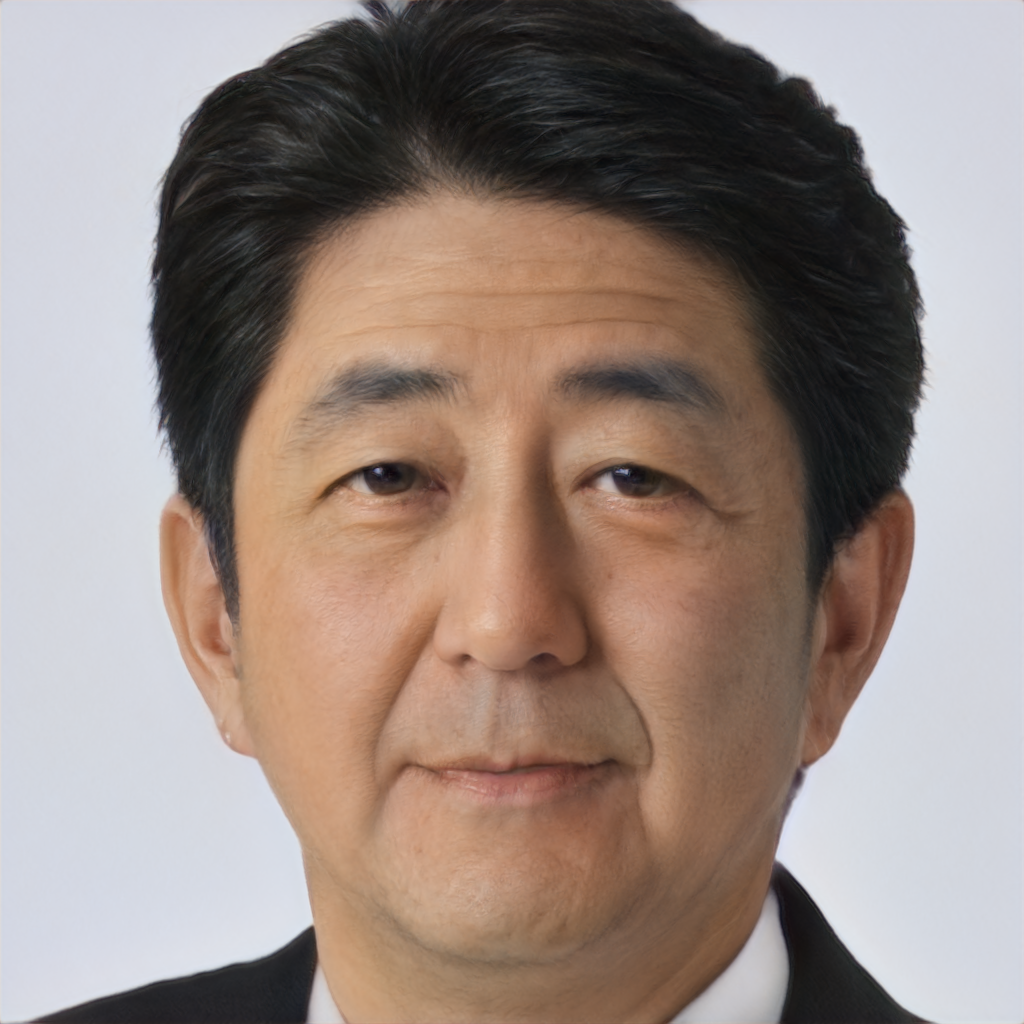

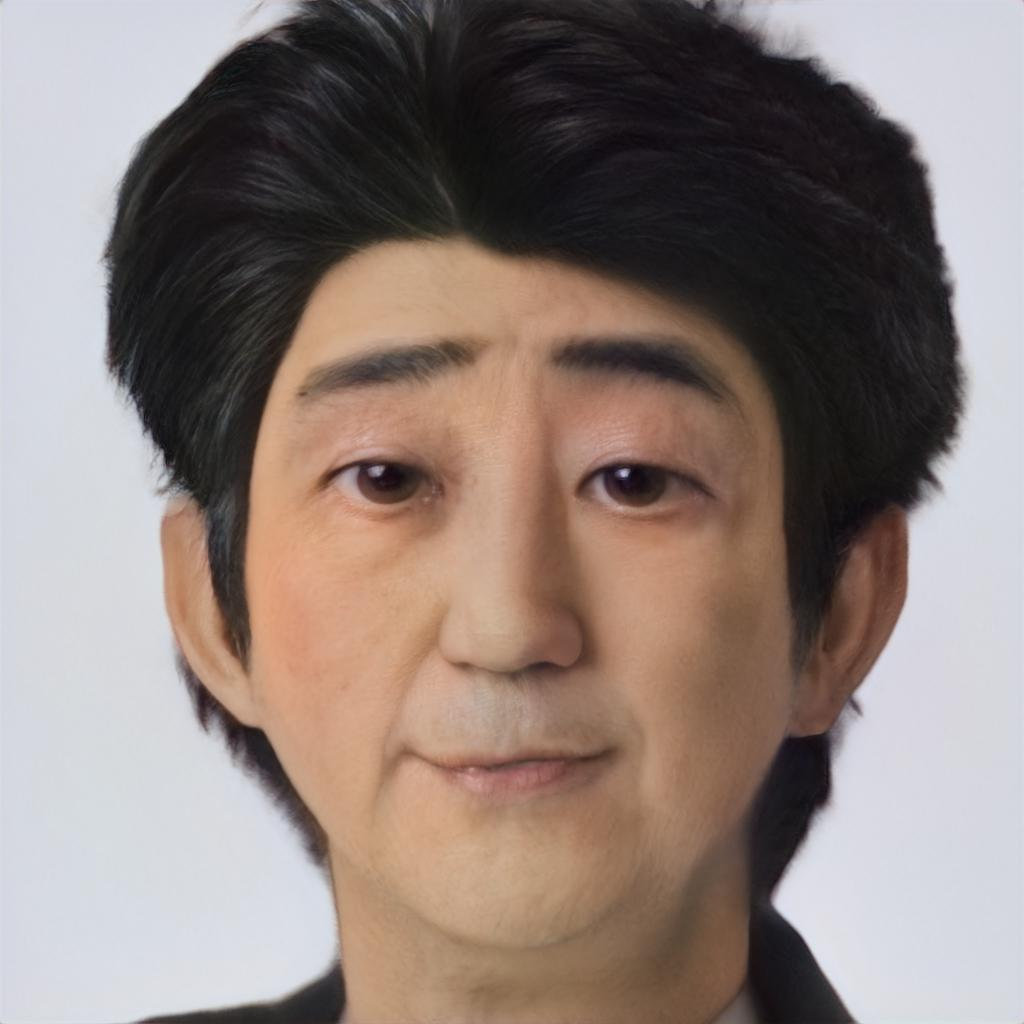

In [ ]:
#显示合成后的图片
from IPython.display import Image 
embedded = Image(filename="generated/example_01.png", width=256)
display(embedded)
tooned = Image(filename="generated/example_01-toon.jpg", width=256)
display(tooned)